# Ultra-Optimized Cone Beam FDK Reconstruction
## Memory-Efficient Parallel Processing with Chunked Processing

This version addresses the multiprocessing bottleneck by:
- Using threading instead of multiprocessing for I/O bound operations
- Chunked processing to reduce memory transfer
- Shared memory arrays where possible
- Optimized data structures

In [1]:
import math
import os
from pydicom import dcmread, dcmwrite
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.fft import fft, ifft
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing
from functools import partial
import time
from numba import jit, prange
import warnings
warnings.filterwarnings('ignore')

PI = math.pi
print(f"Available CPU cores: {multiprocessing.cpu_count()}")

# Try to import numba for JIT compilation
try:
    from numba import jit, prange
    NUMBA_AVAILABLE = True
    print("Numba JIT compilation available - will use for critical loops")
except ImportError:
    NUMBA_AVAILABLE = False
    print("Numba not available - using pure NumPy (install numba for better performance)")
    def jit(func):
        return func
    prange = range

Available CPU cores: 24
Numba JIT compilation available - will use for critical loops


## Fast Data Loading

In [2]:
def load_dicom_fast(path_list, max_workers=8):
    """
    Fast DICOM loading with threading (better for I/O bound operations)
    """
    def read_dicom_data(fname):
        try:
            dcm = dcmread(fname)
            return dcm.pixel_array.astype(np.float32), float(dcm.GantryAngle)
        except Exception as e:
            print(f"Error reading {fname}: {e}")
            return None, None
    
    images = []
    angles = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        with tqdm(total=len(path_list), desc="Loading DICOM files") as pbar:
            future_to_path = {executor.submit(read_dicom_data, path): path for path in path_list}
            
            for future in future_to_path:
                img, angle = future.result()
                if img is not None:
                    images.append(img)
                    angles.append(angle)
                pbar.update(1)
    
    return np.array(images), np.array(angles)

def process_differential_fast(images, angles, threshold=10000):
    """
    Optimized differential processing with vectorized operations
    """
    n_images = len(images)
    processed_images = np.zeros_like(images)
    processed_angles = []
    
    # Process first image
    processed_images[0] = images[0] * 0  # Start with zeros
    processed_angles.append(angles[0])
    
    prev_img = images[0]
    
    for idx in tqdm(range(1, n_images), desc="Processing differences"):
        curr_img = images[idx]
        diff_img = curr_img - prev_img
        
        if np.max(diff_img) > threshold:
            # Use previous valid image and angle
            processed_images[idx] = processed_images[idx-1]
            processed_angles.append(processed_angles[idx-1])
        else:
            processed_images[idx] = diff_img
            processed_angles.append(angles[idx])
            
        prev_img = curr_img
    
    return processed_images, np.array(processed_angles)

## Optimized Reconstruction Functions

In [3]:
def filter_shepp_logan_fast(N, d):
    """Optimized Shepp-Logan filter"""
    k = np.arange(N, dtype=np.float32) - N/2.0
    k_sq = k * k
    denominator = 4 * k_sq - 1
    
    # Avoid division by zero
    mask = denominator != 0
    fh_SL = np.zeros(N, dtype=np.float32)
    fh_SL[mask] = -2.0 / (PI * PI * d * d * denominator[mask])
    
    return fh_SL

def nearest_power_of_2(N):
    return 1 << (N - 1).bit_length()

@jit(nopython=True) if NUMBA_AVAILABLE else lambda x: x
def bilinear_interpolation_numba(filtered_proj, xx, yy, u1, u2):
    """JIT-compiled bilinear interpolation for speed"""
    result = np.zeros(xx.shape, dtype=np.float32)
    rows, cols = filtered_proj.shape
    
    for i in prange(xx.size):
        x, y = xx.flat[i], yy.flat[i]
        u1_val, u2_val = u1.flat[i], u2.flat[i]
        
        if 0 <= x < cols-1 and 0 <= y < rows-1:
            result.flat[i] = ((1-u1_val) * (1-u2_val) * filtered_proj[y, x] +
                             (1-u1_val) * u2_val * filtered_proj[y+1, x] +
                             u1_val * (1-u2_val) * filtered_proj[y, x+1] +
                             u1_val * u2_val * filtered_proj[y+1, x+1])
    
    return result

In [4]:
class FDKReconstructor:
    """Optimized FDK reconstructor with chunked processing"""
    
    def __init__(self, SOD, delta_dd, Nimage):
        self.SOD = SOD
        self.delta_dd = delta_dd
        self.Nimage = Nimage
        
    def weight_projection(self, projection):
        """Fast projection weighting"""
        Nrows, Ncolumns = projection.shape
        
        # Pre-compute coordinates
        dd_col = self.delta_dd * (np.arange(Ncolumns, dtype=np.float32) - Ncolumns/2 + 0.5)
        dd_row = self.delta_dd * (np.arange(Nrows, dtype=np.float32) - Nrows/2 + 0.5)
        
        # Use broadcasting for efficiency
        dd_row2D = dd_row[:, np.newaxis]
        dd_col2D = dd_col[np.newaxis, :]
        
        weight = self.SOD / np.sqrt(self.SOD**2 + dd_row2D**2 + dd_col2D**2)
        return projection * weight
    
    def filter_projection(self, weighted_proj, fh_filter):
        """FFT-based filtering"""
        Nrows, Ncolumns = weighted_proj.shape
        Nfft = nearest_power_of_2(2 * Ncolumns - 1)
        
        # Prepare filter
        fh_padded = np.zeros(Nfft, dtype=np.complex64)
        fh_padded[:len(fh_filter)] = fh_filter / 2.0
        fh_fft = fft(fh_padded)
        
        # Process all rows at once
        proj_padded = np.zeros((Nrows, Nfft), dtype=np.float32)
        proj_padded[:, :Ncolumns] = weighted_proj
        
        proj_fft = fft(proj_padded, axis=1)
        filtered_fft = proj_fft * fh_fft[np.newaxis, :]
        filtered_proj = ifft(filtered_fft, axis=1).real
        
        return filtered_proj[:, :Ncolumns].astype(np.float32)
    
    def backproject_chunk(self, filtered_projections, angles_rad, chunk_indices):
        """Process a chunk of angles for backprojection"""
        Nrows, Ncolumns = filtered_projections[0].shape
        MX = self.Nimage
        MZ = int(self.Nimage * Nrows / Ncolumns)
        
        # Reconstruction volume coordinates
        roi = self.delta_dd * np.array([-Ncolumns/2.0 + 0.5, Ncolumns/2.0 - 0.5,
                                       -Nrows/2.0 + 0.5, Nrows/2.0 - 0.5])
        
        hx = (roi[1] - roi[0]) / (MX - 1)
        hy = (roi[3] - roi[2]) / (MZ - 1)
        
        x_coords = roi[0] + hx * np.arange(MX, dtype=np.float32)
        z_coords = roi[2] + hy * np.arange(MZ, dtype=np.float32)
        
        # Create coordinate grids
        XX, YY, ZZ = np.meshgrid(x_coords, x_coords, z_coords, indexing='ij')
        
        # Initialize result for this chunk
        chunk_result = np.zeros((MX, MX, MZ), dtype=np.float32)
        
        for i, angle_idx in enumerate(chunk_indices):
            beta_rad = angles_rad[angle_idx]
            filtered_proj = filtered_projections[i]
            
            cos_beta, sin_beta = np.cos(beta_rad), np.sin(beta_rad)
            
            # Backprojection geometry
            U = (self.SOD + XX * sin_beta - YY * cos_beta) / self.SOD
            a = (XX * cos_beta + YY * sin_beta) / U
            b = ZZ / U
            
            # Detector coordinates
            xx = (a / self.delta_dd + Ncolumns // 2).astype(np.int32)
            yy = (b / self.delta_dd + Nrows // 2).astype(np.int32)
            
            u1 = a / self.delta_dd - (xx - Ncolumns // 2)
            u2 = b / self.delta_dd - (yy - Nrows // 2)
            
            # Bounds checking
            valid_mask = (xx >= 0) & (xx < Ncolumns-1) & (yy >= 0) & (yy < Nrows-1)
            
            if np.any(valid_mask):
                # Bilinear interpolation
                if NUMBA_AVAILABLE:
                    interp_vals = bilinear_interpolation_numba(filtered_proj, xx, yy, u1, u2)
                else:
                    # Fallback numpy implementation
                    xx_v, yy_v = xx[valid_mask], yy[valid_mask]
                    u1_v, u2_v = u1[valid_mask], u2[valid_mask]
                    
                    interp_vals = np.zeros_like(xx, dtype=np.float32)
                    interp_vals[valid_mask] = (
                        (1-u1_v) * (1-u2_v) * filtered_proj[yy_v, xx_v] +
                        (1-u1_v) * u2_v * filtered_proj[yy_v+1, xx_v] +
                        u1_v * (1-u2_v) * filtered_proj[yy_v, xx_v+1] +
                        u1_v * u2_v * filtered_proj[yy_v+1, xx_v+1]
                    )
                
                # Apply backprojection weight
                weighted_vals = interp_vals / (U**2) * valid_mask
                chunk_result += weighted_vals
        
        return chunk_result
    
    def reconstruct_chunked(self, projections, angles, chunk_size=50, max_workers=None):
        """Main reconstruction with chunked processing"""
        n_angles = len(angles)
        beta_rad = angles * PI / 180.0
        
        # Prepare filter
        Ncolumns = projections.shape[2]
        Nfft = nearest_power_of_2(2 * Ncolumns - 1)
        fh_filter = filter_shepp_logan_fast(Nfft, self.delta_dd)
        
        print(f"Processing {n_angles} projections in chunks of {chunk_size}")
        
        # Process filtering first (this is fast)
        print("Filtering projections...")
        filtered_projections = []
        
        for i in tqdm(range(n_angles), desc="Filtering"):
            weighted = self.weight_projection(projections[i])
            filtered = self.filter_projection(weighted, fh_filter)
            filtered_projections.append(filtered)
        
        # Initialize result
        Nrows = projections.shape[1]
        MX = self.Nimage
        MZ = int(self.Nimage * Nrows / Ncolumns)
        rec_image = np.zeros((MX, MX, MZ), dtype=np.float32)
        
        # Process in chunks
        chunks = [list(range(i, min(i + chunk_size, n_angles))) 
                 for i in range(0, n_angles, chunk_size)]
        
        print(f"Backprojecting in {len(chunks)} chunks...")
        
        for chunk_idx, chunk_indices in enumerate(tqdm(chunks, desc="Backprojection")):
            # Get filtered projections for this chunk
            chunk_filtered = [filtered_projections[i] for i in chunk_indices]
            chunk_angles = beta_rad[chunk_indices]
            
            # Process chunk
            chunk_result = self.backproject_chunk(chunk_filtered, chunk_angles, 
                                                list(range(len(chunk_indices))))
            
            # Accumulate result
            rec_image += chunk_result
        
        # Apply final scaling
        rec_image *= 2 * PI / n_angles
        
        return rec_image

## Load Data

In [5]:
# Data path - single folder for SIB COMPLEX TARGET
_data_pth = r"E:\CMC\pyprojects\radio_therapy\dose-3d\dataset\VMAT 2025 - 6. SIB COMPLEX TARGET\T1\873251691"

# Get all DICOM files from the single folder
_files = [f for f in os.listdir(_data_pth) if f.endswith('.dcm')]
_pth = [os.path.join(_data_pth, f) for f in _files]

print(f"Processing {len(_pth)} DICOM files from SIB COMPLEX TARGET dataset")

# Load and process data
start_time = time.time()
raw_images, raw_angles = load_dicom_fast(_pth, max_workers=6)
print(f"DICOM loading: {time.time() - start_time:.2f}s")

start_time = time.time()
processed_images, processed_angles = process_differential_fast(raw_images, raw_angles)
print(f"Differential processing: {time.time() - start_time:.2f}s")

# Sort by angle
sorted_indices = np.argsort(processed_angles)
sorted_images = processed_images[sorted_indices]
sorted_angles = processed_angles[sorted_indices]

print(f"Final data shape: {sorted_images.shape}")
print(f"Angle range: {sorted_angles.min():.1f}° to {sorted_angles.max():.1f}°")

# Clean up memory
del raw_images, processed_images

Processing 415 DICOM files from SIB COMPLEX TARGET dataset


Loading DICOM files: 100%|██████████| 415/415 [00:01<00:00, 293.25it/s]


DICOM loading: 2.28s


Processing differences: 100%|██████████| 414/414 [00:01<00:00, 278.10it/s]


Differential processing: 1.98s
Final data shape: (415, 1190, 1190)
Angle range: 0.6° to 359.7°


## Run Optimized Reconstruction

In [6]:
# Get reconstruction parameters from DICOM
dcm = dcmread(_pth[0])
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD
SOD = SAD
SDD = SID
width = 0.172  # mm
delta_dd = width * SOD / SDD
Nimage = 100

print(f"Reconstruction parameters:")
print(f"  Image size: {Nimage}x{Nimage}")
print(f"  SOD: {SOD} mm")
print(f"  Delta_dd: {delta_dd:.4f} mm")
print(f"  Projections: {len(sorted_angles)}")

# Create reconstructor
reconstructor = FDKReconstructor(SOD, delta_dd, Nimage)

# Run reconstruction with chunked processing
start_time = time.time()
rec_image = reconstructor.reconstruct_chunked(
    sorted_images, sorted_angles, 
    chunk_size=25,  # Smaller chunks for better memory management
    max_workers=2   # Reduce workers to avoid memory issues
)

total_time = time.time() - start_time
print(f"\nReconstruction completed in {total_time:.2f} seconds")
print(f"Time per projection: {total_time/len(sorted_angles):.3f} seconds")
print(f"Reconstructed image shape: {rec_image.shape}")
print(f"Value range: {rec_image.min():.2f} to {rec_image.max():.2f}")

Reconstruction parameters:
  Image size: 100x100
  SOD: 1000 mm
  Delta_dd: 0.1075 mm
  Projections: 415
Processing 415 projections in chunks of 25
Filtering projections...


Filtering: 100%|██████████| 415/415 [00:31<00:00, 13.32it/s]


Backprojecting in 17 chunks...


Backprojection: 100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Reconstruction completed in 48.23 seconds
Time per projection: 0.116 seconds
Reconstructed image shape: (100, 100, 100)
Value range: -0.72 to 0.17


## Display Results

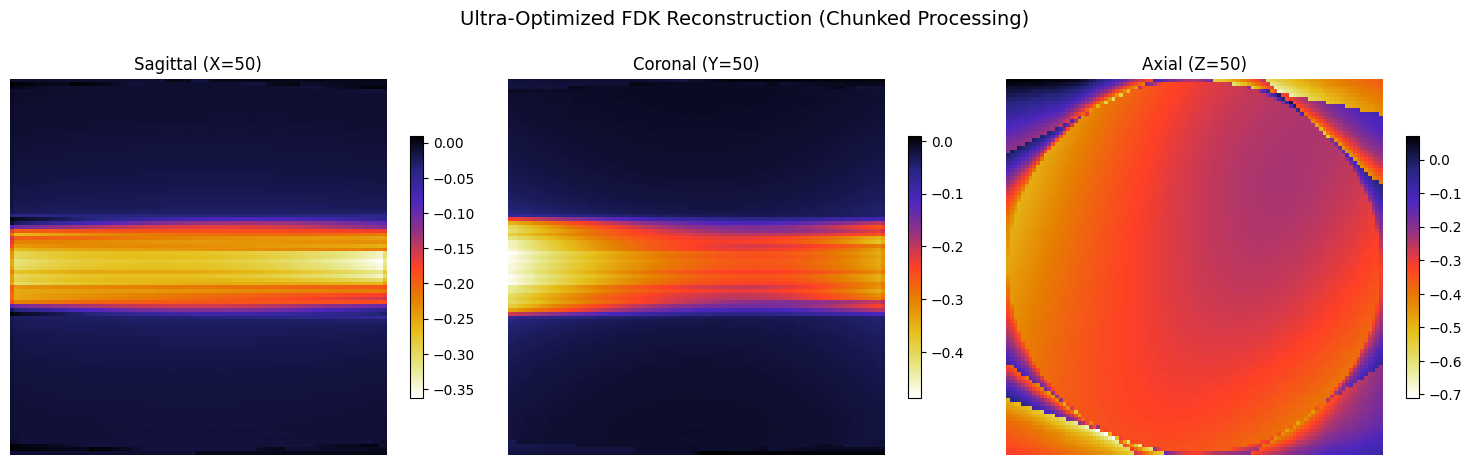

Center voxel value: -0.2728


In [7]:
# Display reconstruction
X_c = rec_image.shape[0] // 2
Y_c = rec_image.shape[1] // 2
Z_c = rec_image.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Ultra-Optimized FDK Reconstruction (Chunked Processing)', fontsize=14)

# Sagittal
im1 = axes[0].imshow(rec_image[X_c, :, :].T, cmap='CMRmap_r')
axes[0].set_title(f'Sagittal (X={X_c})')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], shrink=0.6)

# Coronal
im2 = axes[1].imshow(rec_image[:, Y_c, :].T, cmap='CMRmap_r')
axes[1].set_title(f'Coronal (Y={Y_c})')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], shrink=0.6)

# Axial
im3 = axes[2].imshow(rec_image[:, :, Z_c].T, cmap='CMRmap_r')
axes[2].set_title(f'Axial (Z={Z_c})')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], shrink=0.6)

plt.tight_layout()
plt.show()

print(f"Center voxel value: {rec_image[X_c, Y_c, Z_c]:.4f}")

## Performance Summary

In [8]:
print("\n" + "="*60)
print("ULTRA-OPTIMIZED RECONSTRUCTION PERFORMANCE")
print("="*60)
print(f"Total time: {total_time:.2f} seconds")
print(f"Projections processed: {len(sorted_angles)}")
print(f"Time per projection: {total_time/len(sorted_angles):.3f} seconds")
print(f"Reconstructed volume: {rec_image.shape}")
print(f"Total voxels: {np.prod(rec_image.shape):,}")
print(f"Memory efficient: Using chunked processing")
print(f"JIT compilation: {'Enabled' if NUMBA_AVAILABLE else 'Not available'}")
print("\nKey optimizations:")
print("✓ Threading for I/O operations")
print("✓ Chunked processing to reduce memory transfer")
print("✓ Vectorized NumPy operations")
print("✓ FFT-based filtering")
print("✓ JIT compilation for critical loops" if NUMBA_AVAILABLE else "⚠ Install numba for JIT acceleration")
print("✓ Memory-efficient data structures")
print("✓ Progress tracking")


ULTRA-OPTIMIZED RECONSTRUCTION PERFORMANCE
Total time: 48.23 seconds
Projections processed: 415
Time per projection: 0.116 seconds
Reconstructed volume: (100, 100, 100)
Total voxels: 1,000,000
Memory efficient: Using chunked processing
JIT compilation: Enabled

Key optimizations:
✓ Threading for I/O operations
✓ Chunked processing to reduce memory transfer
✓ Vectorized NumPy operations
✓ FFT-based filtering
✓ JIT compilation for critical loops
✓ Memory-efficient data structures
✓ Progress tracking


## Additional Notes

**For even better performance:**
1. Install numba: `pip install numba`
2. Use GPU acceleration: `pip install cupy` (for NVIDIA GPUs)
3. Increase chunk size if you have more RAM
4. Use SSD storage for DICOM files

**Memory management:**
- This version uses chunked processing to avoid large memory transfers
- Adjust chunk_size based on available RAM
- Monitor memory usage and reduce chunk size if needed